In [1]:
from SOH_func_scaler import *
import matplotlib.pyplot as pl
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

In [2]:
VERSION = 'Epochs' # 수정

FILE_00 = 'data_csv/CYCLE_CSV_data00.csv'
FILE_01 = 'data_csv/CYCLE_CSV_data01.csv'
FILE_02 = 'data_csv/CYCLE_CSV_data02.csv'
FILE_03 = 'data_csv/CYCLE_CSV_data03.csv'
FILE_04 = 'data_csv/CYCLE_CSV_data04.csv'
FILE_05 = 'data_csv/CYCLE_CSV_data05.csv'
FILE_06 = 'data_csv/CYCLE_CSV_data06.csv'
    
RMSE_ = {}
MAE_ = {}
epoch_index = 0

In [3]:
drop_labels_x = ['인덱스', '사이클_번호', '누적_용량(Ah)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']

param = {'seq_len' : 20, 'num_units' : 32, 'num_filters' : 128, 'window' : 3, 'dropout': 0.2, 'num_epochs' : 1000, 'num_dense': 16}

log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 250

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data00.csv => (475, 4)


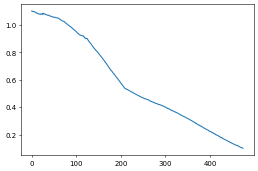

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data01.csv => (515, 4)


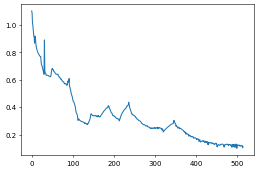

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data05.csv => (515, 4)


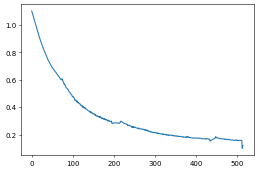

In [4]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_05, drop_labels_x, drop_labels_y)#

In [5]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
x_train01 = seq_gen_x(data01, param['seq_len'])
y_train01 = seq_gen_y(data_cap01, param['seq_len'])
x_test = seq_gen_x(data_test, param['seq_len'])
y_test = seq_gen_y(data_cap_test, param['seq_len'])
print(x_train00.shape)
print(y_train00.shape)
print(x_train00[0, 0:6, 1])
print(y_train00[0, :6])

(455, 20, 4)
(455, 1, 1)
[1.1       1.0982642 1.0979633 1.0960112 1.0969539 1.0957274]
[[1.0746659]]


In [6]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = False))
model.add(layers.Dense(param['num_dense']))
model.add(layers.Dense(1))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

ValueError: `TimeDistributed` Layer should be passed an `input_shape ` with at least 3 dimensions, received: (None, 32)

In [ ]:
for i in range(11):
    epoch_index += param['num_epochs']
    
    callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                    TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
    fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)
    callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                    TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
    fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)
    
    RMSE_[f'{epoch_index}'], MAE_[f'{epoch_index}'], Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True, plot = False)
    print(f'RMSE({RMSE_[f"{epoch_index}"]:.4f}), MAE({MAE_[f"{epoch_index}"]:.4f})')

Epoch 1/1000
10/10 - 3s - loss: 0.1352 - val_loss: 0.0271 - 3s/epoch - 312ms/step
Epoch 2/1000
10/10 - 0s - loss: 0.0568 - val_loss: 0.0065 - 91ms/epoch - 9ms/step
Epoch 3/1000
10/10 - 0s - loss: 0.0388 - val_loss: 0.0189 - 74ms/epoch - 7ms/step
Epoch 4/1000
10/10 - 0s - loss: 0.0284 - val_loss: 0.0041 - 84ms/epoch - 8ms/step
Epoch 5/1000
10/10 - 0s - loss: 0.0184 - val_loss: 0.0060 - 68ms/epoch - 7ms/step
Epoch 6/1000
10/10 - 0s - loss: 0.0117 - val_loss: 0.0031 - 82ms/epoch - 8ms/step
Epoch 7/1000
10/10 - 0s - loss: 0.0076 - val_loss: 0.0023 - 80ms/epoch - 8ms/step
Epoch 8/1000
10/10 - 0s - loss: 0.0056 - val_loss: 0.0022 - 79ms/epoch - 8ms/step
Epoch 9/1000
10/10 - 0s - loss: 0.0043 - val_loss: 0.0019 - 81ms/epoch - 8ms/step
Epoch 10/1000
10/10 - 0s - loss: 0.0033 - val_loss: 0.0017 - 86ms/epoch - 9ms/step
Epoch 11/1000
10/10 - 0s - loss: 0.0026 - val_loss: 0.0015 - 80ms/epoch - 8ms/step
Epoch 12/1000
10/10 - 0s - loss: 0.0021 - val_loss: 0.0015 - 77ms/epoch - 8ms/step
Epoch 13/1000

IndexError: index 495 is out of bounds for axis 0 with size 495

In [ ]:
x = list(RMSE_.keys())
y = list(RMSE_.values())
print(RMSE_)
pl.figure(dpi = 150, figsize=(7, 3))
line = pl.plot(x, y, marker = '.')
pl.rc('axes', labelsize =1)
pl.setp(line, linewidth=0.7)
for i, u in enumerate(x):
    pl.text(u, y[i], f'{y[i]:.5f}', fontsize = 5, horizontalalignment = 'center', verticalalignment = 'bottom')
pl.savefig(f'outputs\{VERSION}\RMSEGraph.png')
pl.show()